# Model Selection

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import learning_curve, validation_curve
import time

# load processed data
train = pd.read_csv('../data/processed/train.csv')
X_test = pd.read_csv('../data/processed/test.csv')

y_train = train['status_group']
X_train = train.drop(['status_group'], axis = 1)

test_ids = pd.read_csv('/Users/donaldfung/Documents/Github/datascience/Projects/Pump it Up - Data Mining the Water Table/data/raw/test.csv', usecols = ['id'])

outcomes = {0:'functional', 
            1:'functional needs repair', 
            2:'non functional'}

random_state = 5

I loaded the data and extracted the target column from the training set.  I also loaded the IDs from the raw `test.csv` file.  These IDs will be added as a requirment in the final submission file.  

I have also created a dictionary called `outcomes` to keep track of the class labels. This will come in handy when converting the encoded predictions into strings for the final submission.   

In [2]:
def save_predictions(ids = None, predictions = None, filepath = None):
    """Prepare submissions file"""
    submission = pd.DataFrame({'id': ids, 'status_group': predictions})
    submission['status_group'] = submission['status_group'].apply(lambda x: reverse_transform(x))
    submission.to_csv(path_or_buf = filepath, index = False)
    print("File saved!")
            
def reverse_transform(x):
    """Converts numerical labels to strings"""
    x = outcomes[x]
    return x

I created a function to prepare the final submission file.  It also converts the numerically encoded predictions into strings before saving the file.

In [3]:
def fit(model, X, y, n_folds, random_state):
    """Evaluate Model Performance"""
    scores = cross_val_score(estimator = model,
                             X = X,
                             y = y,
                             cv = n_folds, 
                             n_jobs = -1)
    print('CV accuracy scores:', scores)
    print('\nCV accuracy: {} +/- {}'.format(np.mean(scores), np.std(scores)))
    
lr = LogisticRegression(random_state = random_state)
fit(model = lr, X = X_train, y = y_train, n_folds = 5, random_state = random_state)

CV accuracy scores: [ 0.7472435   0.74589681  0.74385522  0.74006734  0.75425156]

CV accuracy: 0.7462628848957399 +/- 0.004671105530607837


I tested the performance of a Logistic Regression classifier on the data.  Without modifying any of the classifier's parameters, the classifier produced an average accuracy of approximately 74.6% on the validation set.  Note that the `cross_val_score` method performs a stratified k-fold cross-validation over the training set.  

There is a lot of room to improve the current accuracy score.  It would be interesting to identify if the model in its current state is experiencing bias or variance.  We can use learning curves to see determine this.  The function below will be used to plot the learning curve:

In [6]:
def plot_learning_curve(estimator, estimator_name, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=None, save = False):
    
    start = time.time()
    train_sizes, train_scores, test_scores=learning_curve(estimator=estimator,
                                           X=X,
                                           y=y,
                                           train_sizes=train_sizes,
                                           cv=cv,
                                           n_jobs=n_jobs)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')
    
    plt.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='skyblue')
    
    plt.plot(train_sizes, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')
    
    plt.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')
    
    plt.grid()
    plt.title(title)
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.6, 1.0])
    plt.tight_layout()
    if save:
        plt.savefig('../reports/figures/learning_curve_{}.png'.format(estimator_name), dpi=300)
        print('Figure saved!')
        
    end = time.time()
    print('Finished plotting learning curve.  Time elapsed:', end - start)
    plt.show()

Figure saved!
Finished plotting learning curve.  Time elapsed: 62.7213659286499


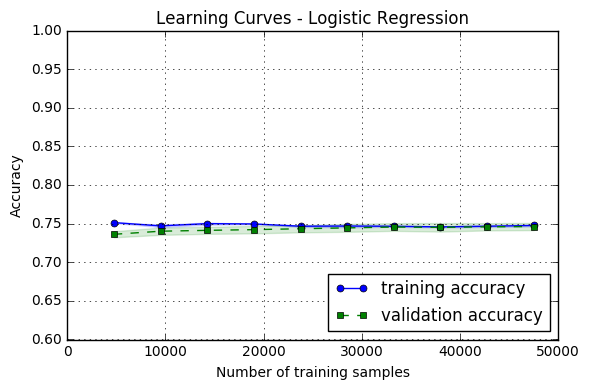

In [7]:
estimator_name = 'Logistic_Regression'
title = 'Learning Curves - Logistic Regression'
# plot learning curve for the Logistic Regression model
plot_learning_curve(estimator = lr, 
                    estimator_name = estimator_name,
                    title = title, 
                    X = X_train, 
                    y = y_train, 
                    ylim=(0.5, 1.01), 
                    cv=5, 
                    n_jobs=-1, 
                    train_sizes = np.linspace(0.1, 1.0, 10),
                    save = True)

We can attempt to improve the accuracy of this model by looking to how a change in C, the inverse of regularization affects performance.  I will plot a validation curve to see the effects of different values for C on the accuracy.  

In [4]:
def plot_validation_curve(estimator, estimator_name, title, X, y, param_range, cv=None, n_jobs=None, save = False):

    start = time.time()
    train_scores, test_scores = validation_curve(
                                estimator=estimator, 
                                X=X, 
                                y=y, 
                                param_name='C', 
                                param_range=param_range,
                                cv=cv,
                                n_jobs=n_jobs)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(param_range, train_mean, 
             color='skyblue', marker='o', 
             markersize=5, label='training accuracy')

    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color='skyblue')

    plt.plot(param_range, test_mean, 
             color='green', linestyle='--', 
             marker='s', markersize=5, 
             label='validation accuracy')

    plt.fill_between(param_range, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color='green')

    plt.grid()
    plt.xscale('log')
    plt.legend(loc='lower right')
    plt.xlabel('Parameter C')
    plt.ylabel('Accuracy')
    plt.ylim([0.6, 1.0])
    plt.tight_layout()
    if save:
        plt.savefig('../reports/figures/validation_curve_{}.png'.format(estimator_name), dpi=300)
    end = time.time()
    print('Finished plotting validation curve.  Time elapsed:', end - start)
    plt.show()

Finished plotting validation curve.  Time elapsed: 104.0257158279419


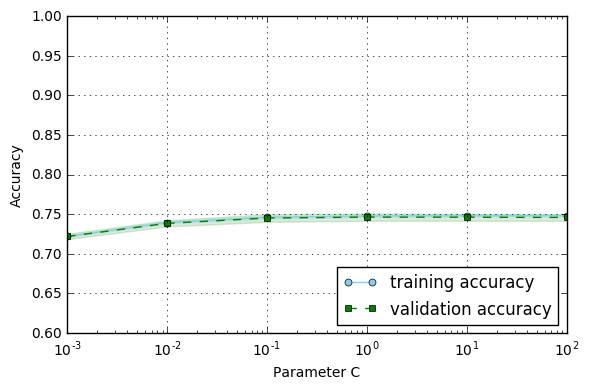

In [7]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
title = 'Validation Curve - Logistic Regression'
plot_validation_curve(estimator = lr,
                      estimator_name = estimator_name,
                      title = title,
                      X=X_train,
                      y=y_train,
                      param_range = param_range, 
                      cv=5, 
                      n_jobs=-1, 
                      save = True)

It seems as though 0.1 is the optimal value for C.  There wasn't' any improvement in using other values of C.  

It would be interesting to see if adjusting the class weights have an effect on the accuracy.  Remember that the classes are imbalanced.  This setting may not have a positive impact on the test set, given that the classes may be distributed differently to the training set.

Finished plotting validation curve.  Time elapsed: 98.06138920783997


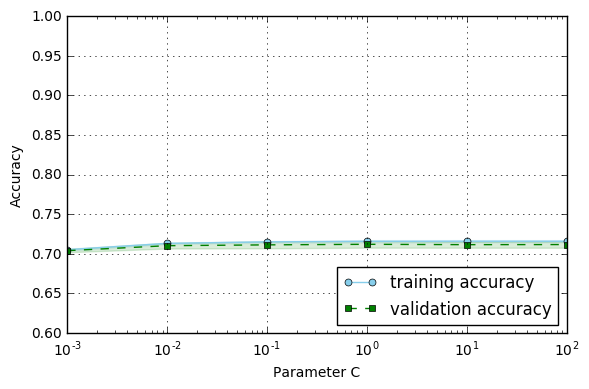

In [8]:
lr = LogisticRegression(random_state = random_state, class_weight = 'balanced')

plot_validation_curve(estimator = lr,
                      estimator_name = estimator_name,
                      title = title,
                      X=X_train,
                      y=y_train,
                      param_range = param_range, 
                      cv=5, 
                      n_jobs=-1, 
                      save = True)

In [6]:
def predict(model, X_train, y_train, X_test, random_state):
    preds = model.fit(X_train, y_train).predict(X_test)
    return preds

predictions=predict(model=lr,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            random_state=random_state)

# prepare first submission
save_predictions(ids = test_ids['id'], predictions = predictions, filepath = '../reports/submissions/submission4.csv')

File saved!
